In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences

# data prepar

In [240]:
# Load gold historical data from Yahoo Finance
data = yf.download('GC=F', start='2014-01-01', end='2024-11-25') # โหลดข้อมูลมาแล้วระบุวันเริ่มกับวันสุดท้าย

[*********************100%***********************]  1 of 1 completed


In [241]:
data['Return'] = data['Close'].pct_change() # ทำค่าผลต่างเป็นเปอร์เซ็นจากวันปัจจุบันและวันก่อนหน้า return ก็คือผลตอบแทนที่ดได้จากราคาปิดวันนี้เทียบกับเมื่อวาน

# Add more technical indicators
# หา Simple Moving Average ช่วง 10 และ 50 วัน
data['SMA_15'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=15)
data['SMA_30'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=30)
data['SMA_60'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=60)

# หา Relative Strength Index ในช่วง 14 วัน
# หาก RSI ต่ำกว่า 30% จะเรียกว่าภาวะ “ขายมากเกินไป” (Oversold)
# หาก RSI สูงกว่า 70% จะเรียกว่าภาวะ “ซื้อมากเกินไป” (Overbought)
data['RSI'] = ta.RSI(data['Close'].to_numpy().flatten(), timeperiod=14)

# หา Moving Average Convergence Divergence ตัว MACD หาได้จากความต่างของ EMA (Exponential Moving Average) สองเส้นหรือ EMA12 - EMA26
# เอาไว้ดูคู่กับ signal line เพื่อประกอบการตัดสินใจจังหวะซื้อหรือขาย
data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'].to_numpy().flatten(), fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands กรอบราคาที่สามารเหวี่ยงไปได้ทั้งกรอบบน กรอบล่าง
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'].to_numpy().flatten(), timeperiod=20)

# หา momentum ซึ่งเป็นอัตราเร่งของราคา
data['Momentum'] = ta.MOM(data['Close'].to_numpy().flatten(), timeperiod=10)

# หาความผันผวนของราคาปิดเมื่อเทียบกับราคาสูงสุดและต่ำสุด
data['Volatility'] = ta.ATR(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), timeperiod=14)  # Added Volatility

# หาค่า Stochastic ออกมาเป็นเปอร์เซ็นเพื่อดูพฤติกรรมการซื้อขาย เพื่อหาจุดที่จะเก็งกำไร ส่วนใหญ่ทำในระยะสั้น
data['Stochastic'] = ta.STOCH(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), fastk_period=14, slowk_period=3)[0]  # Added Stochastic

In [242]:
# ทำ label เป็น buy, sell
# data['Target'] = np.where(data['Return'].shift(-1) > 0, 1, 0)
data["Target"] = data["Close"]["GC=F"].shift(-1)
data.dropna(inplace=True)
data.head(100)

Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_15,SMA_30,SMA_60,RSI,MACD,MACD_Signal,BB_upper,BB_middle,BB_lower,Momentum,Volatility,Stochastic,Target
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2014-03-28 00:00:00+00:00,1293.800049,1293.800049,1299.400024,1285.900024,1292.199951,65486,-0.000695,1337.580005,1334.979997,1293.760000,37.911234,-2.326473,7.779243,1389.031398,1339.079999,1289.128600,-85.199951,15.337535,2.496058,1283.400024
2014-03-31 00:00:00+00:00,1283.400024,1283.400024,1298.800049,1282.400024,1294.300049,4121,-0.008038,1333.713338,1333.793331,1294.733333,34.888714,-5.171755,5.189043,1390.939361,1335.745001,1280.550641,-89.500000,15.413427,2.801869,1279.599976
2014-04-01 00:00:00+00:00,1279.599976,1279.599976,1287.900024,1277.300049,1285.099976,884,-0.002961,1329.253337,1332.289998,1295.419999,33.827481,-7.645165,2.622202,1393.185250,1332.834998,1272.484745,-79.400024,15.069609,3.473773,1290.500000
2014-04-02 00:00:00+00:00,1290.500000,1290.500000,1294.099976,1280.199951,1280.199951,1099,0.008518,1323.933333,1331.286666,1296.298332,39.511091,-8.626380,0.372485,1393.318675,1330.350000,1267.381325,-50.900024,15.028923,4.833967,1284.400024
2014-04-03 00:00:00+00:00,1284.400024,1284.400024,1293.500000,1282.699951,1290.800049,775,-0.004727,1318.080005,1330.196667,1297.214998,37.566482,-9.783440,-1.658700,1392.183755,1326.985004,1261.786252,-46.099976,14.726860,6.602354,1303.199951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-13 00:00:00+00:00,1312.800049,1312.800049,1312.800049,1305.000000,1308.800049,238,0.003056,1299.553345,1307.646667,1294.613334,55.497380,0.981805,-0.654439,1322.195171,1302.175000,1282.154829,17.900024,11.762916,72.741874,1313.900024
2014-08-14 00:00:00+00:00,1313.900024,1313.900024,1316.400024,1309.699951,1311.800049,320,0.000838,1301.106681,1307.086670,1294.936668,56.064428,1.660192,-0.191513,1321.682630,1302.035004,1282.387377,32.599976,11.401284,77.058433,1304.500000


# funtion for split data

In [250]:
def z_scaled(data, features):
    for i in features:
        data[i] = (data[i] - data[i].mean()) / data[i].std()
    return data

def min_max_scaled(data, features):
    for i in features:
        data[i] = (data[i] - data[i].min()) / (data[i].max() - data[i].min())
    return data

def max_abs_scaled(data, features):
    for i in features:
        data[i] = data[i] / data[i].abs().max()
    return data

from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0, 1))
def sklearn_scaled(data, feature):
    # scale = MinMaxScaler(feature_range=(0, 1))
    for i in feature:
        data[i] = scale.fit_transform(data[i].values.reshape(-1, 1))
    return data

In [178]:
def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    features = [
        'Return', 'SMA_15', 'SMA_30', 'SMA_60', 'RSI', 'MACD', 'MACD_Signal',
        'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic'
    ]
    
    data = min_max_scaled(data, features)

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    pre_date = data.iloc[split_range:].index.to_list()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test, date

In [179]:
x_train, y_train, x_test, y_test, date = split_data(data, data_range=30)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date))

(2115, 30, 13) (2115, 1) (507, 30, 13) (507, 1)
(2115, 30, 13) (2115, 1) (507, 30, 13) (507, 1) 507


# ลองใหม่

In [252]:
def new_split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    features = [
        'SMA_15', 'SMA_30', 'SMA_60', 'RSI', 'MACD', 'MACD_Signal',
        'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic'
    ]
    data = sklearn_scaled(data, features)
    data = sklearn_scaled(data, ["Target"])

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    pre_date = data.iloc[split_range:].index.to_list()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])

    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test, date

In [258]:
x_train, y_train, x_test, y_test, date = new_split_data(data.copy(), data_range=30, train_ratio=0.5)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date))

(1310, 30, 12) (1310,) (1311, 30, 12) (1311,)
(1310, 30, 12) (1310,) (1311, 30, 12) (1311,) 1311


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [248]:
def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    # model.add(LSTM(neurons, input_shape=(range_input, n_feature), return_sequences=True))
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    # model.add(LSTM(neurons))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Epoch 1/50


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2856e-04 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5778e-04 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1685e-04
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0931e-04 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1569e-04 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0079e-04 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3448e-04 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2039e-04 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9528e-04 
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7948e-04 
Epoch

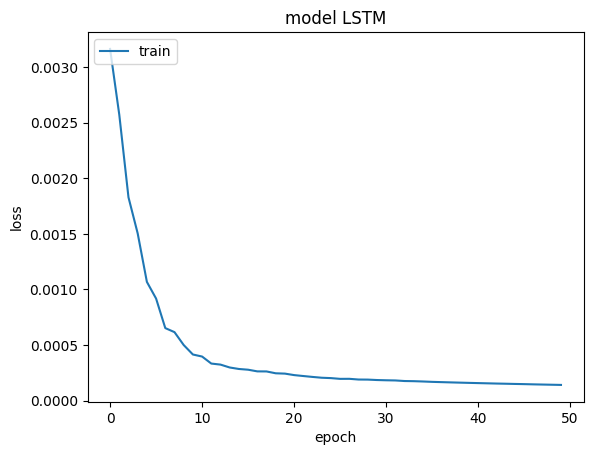

In [259]:
model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2])
history1 = model.fit(x_train, y_train, batch_size=1000, epochs=50)
plt.plot(history1.history['loss'])
plt.title('model LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [260]:
scale_predict = model.predict(x_test)
predict_lstm = scale.inverse_transform(scale_predict)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


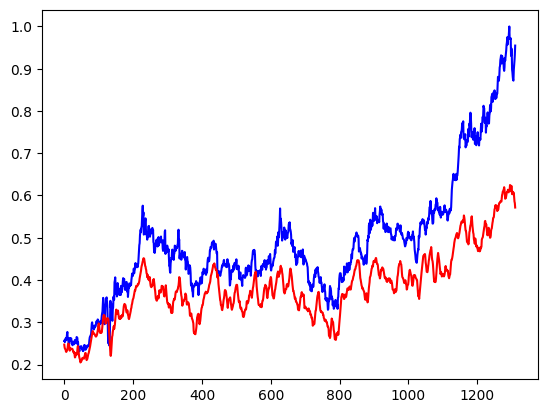

In [261]:
plt.plot(y_test, c="b")
plt.plot(scale_predict, c="r")

# draf model

In [186]:
def create_cnn1d_gru_model(input_shape, gru_units=16):
    model = models.Sequential()
    
    # CNN Layers (Convolutional Layer + MaxPooling)
    model.add(layers.Conv1D(13, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    
    # model.add(layers.Conv1D(64, 3, activation='relu'))
    # model.add(layers.MaxPooling1D(2))
    
    # model.add(layers.Conv1D(128, 3, activation='relu'))
    # model.add(layers.MaxPooling1D(2))
    
    # Flatten the output from CNN layers to be input to GRU
    model.add(layers.Flatten())
    
    # GRU Layer
    model.add(layers.Reshape((-1, 13)))  # Reshape for GRU, where -1 is sequence length, 128 is feature dimension
    model.add(layers.GRU(gru_units, return_sequences=False))  # GRU Layer
    
    # Fully Connected Layer (Dense Layer)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Output layer 2 classes

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.SparseCategoricalCrossentropy(), 
        # metrics=[metrics.SparseCategoricalAccuracy(), [metrics.TruePositives(), metrics.TrueNegatives(), metrics.FalsePositives(), metrics.FalseNegatives()],
        #          [metrics.Precision(), metrics.Recall(), metrics.F1Score()]]
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    
    return model

my_model = create_cnn1d_gru_model(x_train.shape[1:])

# train

In [187]:
history = my_model.fit(x_train, y_train, batch_size=300, epochs=50)

# save model 
# my_model.save("model/simple_model.h5")

# load model
# my_model = models.load_model("model/simple_model.h5")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.4792
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.4919
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4872
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.4812
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.4899
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.4824 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.4892
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4854
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4981
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6933 - sparse_categorical_acc

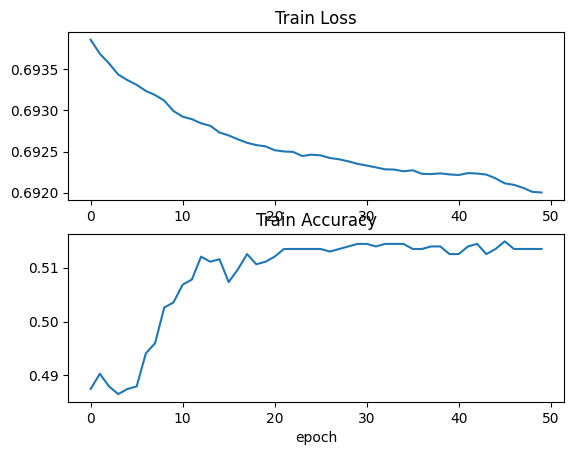

In [188]:
plt.subplot(2, 1, 1)
plt.title("Train Loss")
plt.plot(history.history["loss"])
plt.subplot(2, 1, 2)
plt.title("Train Accuracy")
plt.xlabel("epoch")
plt.plot(history.history["sparse_categorical_accuracy"])
plt.show()

# predict

In [189]:
prediction = my_model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [190]:
predict_class = np.where(prediction[:,0] < prediction[:,1], 1, 0)
tmp = {"raw_class_0":prediction[:,0], "raw_class_1":prediction[:,1], "predict_class":predict_class, "real_class":y_test.reshape(-1)}
df = pd.DataFrame(tmp)
df.to_csv("csv_file/test_predict.csv", index=False)

# evaluate

In [191]:
# confusion matrix
tf.math.confusion_matrix(y_test, predict_class)
# test accuracy
# for i in range((predict_class))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  0, 232],
       [  0, 275]])>

# back test

In [176]:
# Backtesting with updated features and better portfolio simulation
capital = 10  # Initial capital
capital_history = []

my_dict = { "price_today": [], "price_next_day": [], "prediction": [],
            "profit": [], "in_befo_fee":[], "in_afte_fee":[],
            "out_befo_fee":[], "out_afte_fee":[]
            }

# Map test indices to the original DataFrame
# test_indices = y_test.index.to_list() # คาดว่าวันไม่เรียง

# Trade logic with stop-loss and take-profit to reduce risk
for i in range(len(date)-1):
    price_today = data['Close'].loc[date[i]]["GC=F"]
    price_next_day = data['Close'].loc[date[i+1]]["GC=F"]

    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.05  # 5% take profit

    my_dict["in_befo_fee"].append(capital)
    capital *= 0.999 # หักค่าธรรมเนีม
    my_dict["in_afte_fee"].append(capital)

    my_dict["prediction"].append(predict_class[i])
    # Long position logic (buy if predicted up)
    if predict_class[i] == 1:
        profit = (price_next_day - price_today) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered
    else:  # Short position logic (sell if predicted down)
        profit = (price_today - price_next_day) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered    

    capital += profit
    
    my_dict["out_befo_fee"].append(capital)
    capital *= 0.999
    my_dict["out_afte_fee"].append(capital)

    capital_history.append(capital)
    my_dict["price_today"].append(price_today)
    my_dict["price_next_day"].append(price_next_day)
    my_dict["profit"].append(profit)


In [149]:
df = pd.DataFrame(my_dict)
df.to_csv("csv_file/back_test_history.csv", index=False)

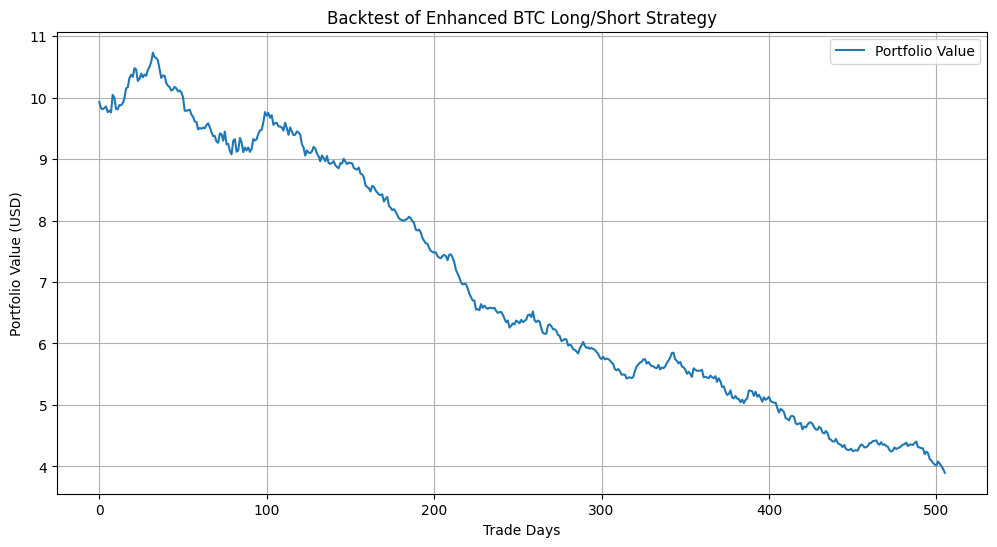

In [177]:
# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest of Enhanced BTC Long/Short Strategy')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

# call cagr, max drawdown, sd

In [ ]:
import cal_def

cagr = cal_def.cal_cagr(1, capital_history)
max_dd = cal_def.cal_max_drawdown(capital_history)
sd = cal_def.cal_sd(capital_history)

print(cagr, max_dd, sd)

-29.82258753462399 (0.4395293320388187, 37, 500) 1.3702116004560747


# เพิ่มเติมจาก gpt

gpt ชุด 1

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import backtrader as bt # อันนี้น่าสนใจในการทำ backtest

# Step 1: ดึงข้อมูลจาก Yahoo Finance
data = yf.download('BTC-USD', start='2023-11-20', end='2024-11-20', progress=False)

# Step 2: สร้าง Feature สำหรับ Machine Learning
data['price_roc'] = data['Close'].pct_change() * 100  # Rate of Change ของราคา
data['volume_roc'] = data['Volume'].pct_change() * 100  # Rate of Change ของ volume
data = data.dropna()  # ลบค่า NaN ที่เกิดจากการคำนวณ

# Step 3: กำหนด Target (1 = long, -1 = short)
data['target'] = 0
data.loc[data['price_roc'] > 0, 'target'] = 1  # long หากราคาเพิ่มขึ้น
data.loc[data['price_roc'] < 0, 'target'] = -1  # short หากราคาลดลง

# Step 4: การเตรียมข้อมูลสำหรับการฝึก Machine Learning
X = data[['price_roc', 'volume_roc']]  # Features
y = data['target']  # Target

# แบ่งข้อมูลเป็น train/test (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# สร้างและฝึกโมเดล Machine Learning
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ทำนายผลใน test set
y_pred = model.predict(X_test)

# แสดงผลการทำนาย
print(classification_report(y_test, y_pred))

# Step 5: สร้าง Strategy สำหรับ Backtrader
class MLStrategy(bt.Strategy):
    # กำหนดค่า parameter สำหรับการเข้าสู่ตลาด
    def __init__(self):
        self.model = model
        self.data_close = self.datas[0].close
        self.data_volume = self.datas[0].volume
        self.X = pd.DataFrame({
            'price_roc': self.data_close.pct_change() * 100,
            'volume_roc': self.data_volume.pct_change() * 100
        })
        self.X = self.X.fillna(0)  # แทนที่ NaN ด้วย 0 เพื่อให้ไม่เกิดข้อผิดพลาดในการทำนาย
        self.y_pred = self.model.predict(self.X.values)  # ทำนายคำสั่ง Long/Short
    
    def next(self):
        if self.y_pred[-1] == 1:  # หากทำนาย long
            if not self.position:  # ถ้ายังไม่ได้เปิด position
                self.buy()
        elif self.y_pred[-1] == -1:  # หากทำนาย short
            if not self.position:  # ถ้ายังไม่ได้เปิด position
                self.sell()

# Step 6: การทำ Backtest โดยใช้ Backtrader
cerebro = bt.Cerebro()

# แปลงข้อมูลเป็น backtrader feed
data_bt = bt.feeds.PandasData(dataname=data)

# เพิ่มข้อมูลลงใน cerebro
cerebro.adddata(data_bt)

# เพิ่ม strategy ที่สร้างขึ้น
cerebro.addstrategy(MLStrategy)

# ตั้งค่าขนาดการลงทุนเริ่มต้น
cerebro.broker.set_cash(10000)

# ตั้งค่าค่าคอมมิชชั่น (เช่น 0.1% ต่อการเทรด)
cerebro.broker.set_commission(commission=0.001)

# รัน backtest
cerebro.run()

# แสดงกราฟผลลัพธ์
cerebro.plot()

gpt ชุด 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ตัวอย่างการสร้างโมเดล CNN + GRU

# สร้างโมเดล CNN + GRU
def create_cnn_gru_model(input_shape, gru_units=64):
    model = models.Sequential()
    
    # CNN Layers (Convolutional Layer + MaxPooling)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output from CNN layers to be input to GRU
    model.add(layers.Flatten())
    
    # GRU Layer
    model.add(layers.Reshape((-1, 128)))  # Reshape for GRU, where -1 is sequence length, 128 is feature dimension
    model.add(layers.GRU(gru_units, return_sequences=False))  # GRU Layer
    
    # Fully Connected Layer (Dense Layer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer (10 classes, change as needed)
    
    return model

# สร้างโมเดล CNN + GRU
input_shape = (64, 64, 3)  # ขนาดของภาพ (64x64 พิกเซล, 3 แชนแนล RGB)
model = create_cnn_gru_model(input_shape)

# คอมไพล์โมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# แสดงสรุปของโมเดล
model.summary()

# ตัวอย่างการฝึกโมเดล
# สมมุติว่าเรามีข้อมูล train_X และ train_Y เป็นข้อมูลที่ประกอบด้วยลำดับของภาพ
train_X = np.random.rand(100, 10, 64, 64, 3)  # 100 ตัวอย่าง, 10 ภาพในแต่ละลำดับ
train_Y = np.random.randint(0, 10, (100,))  # 100 ป้ายกำกับ (10 คลาส)

# การฝึกโมเดล
model.fit(train_X, train_Y, epochs=10, batch_size=16)
